In [6]:
conda install quandl

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [7]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [8]:
# Configure API key 

quandl.ApiConfig.api_key = 'xQyWsEsYuXg2XeFnKuuc'

In [9]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FRED/DSPI')

In [10]:
data.head()

,Value
Date,
1959-01-01,351.5
1959-02-01,352.9
1959-03-01,355.2
1959-04-01,358.2
1959-05-01,360.3


In [11]:
data.shape

(756, 1)

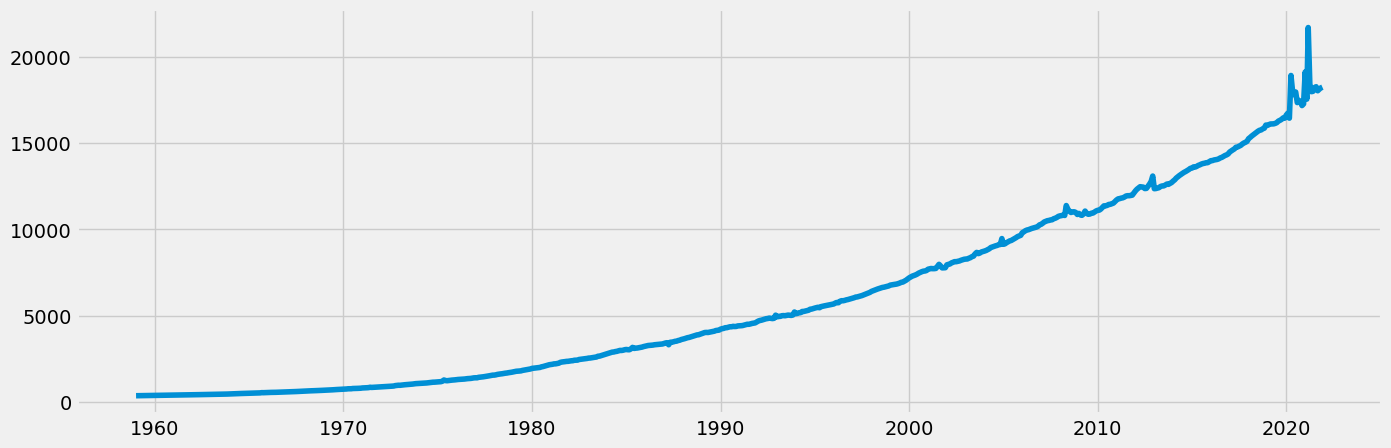

In [12]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### Subsetting, wrangling, and cleaning time-series data

In [13]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [14]:
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01')]

In [15]:
data_sub.head()

,Date,Value
492,2000-01-01,7184.0
493,2000-02-01,7234.5
494,2000-03-01,7285.2
495,2000-04-01,7316.4
496,2000-05-01,7352.9


In [16]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2000-01-01,7184.0
2000-02-01,7234.5
2000-03-01,7285.2
2000-04-01,7316.4
2000-05-01,7352.9


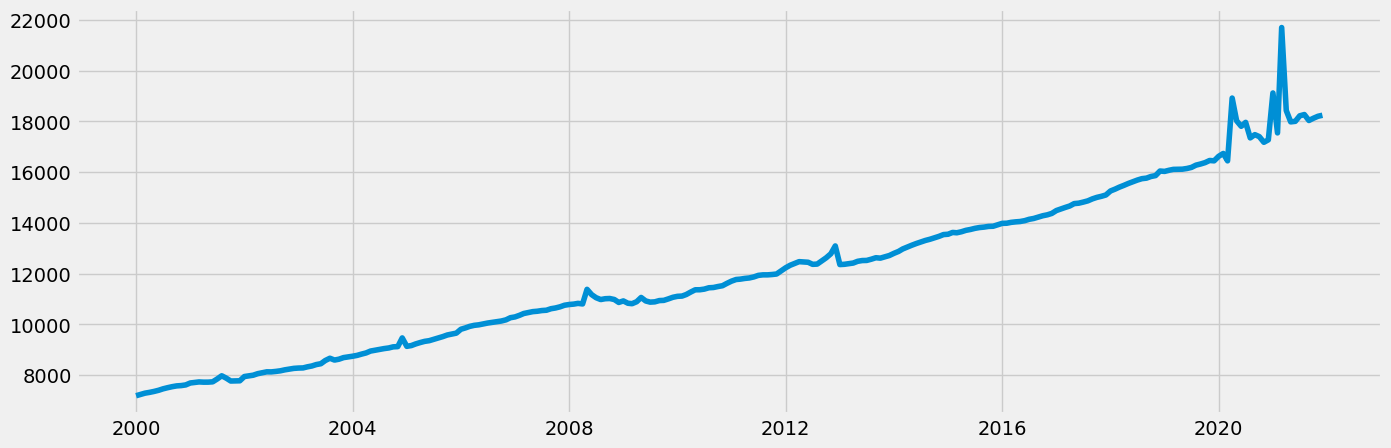

In [17]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [18]:
# Check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

### Decompose 

In [25]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [26]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

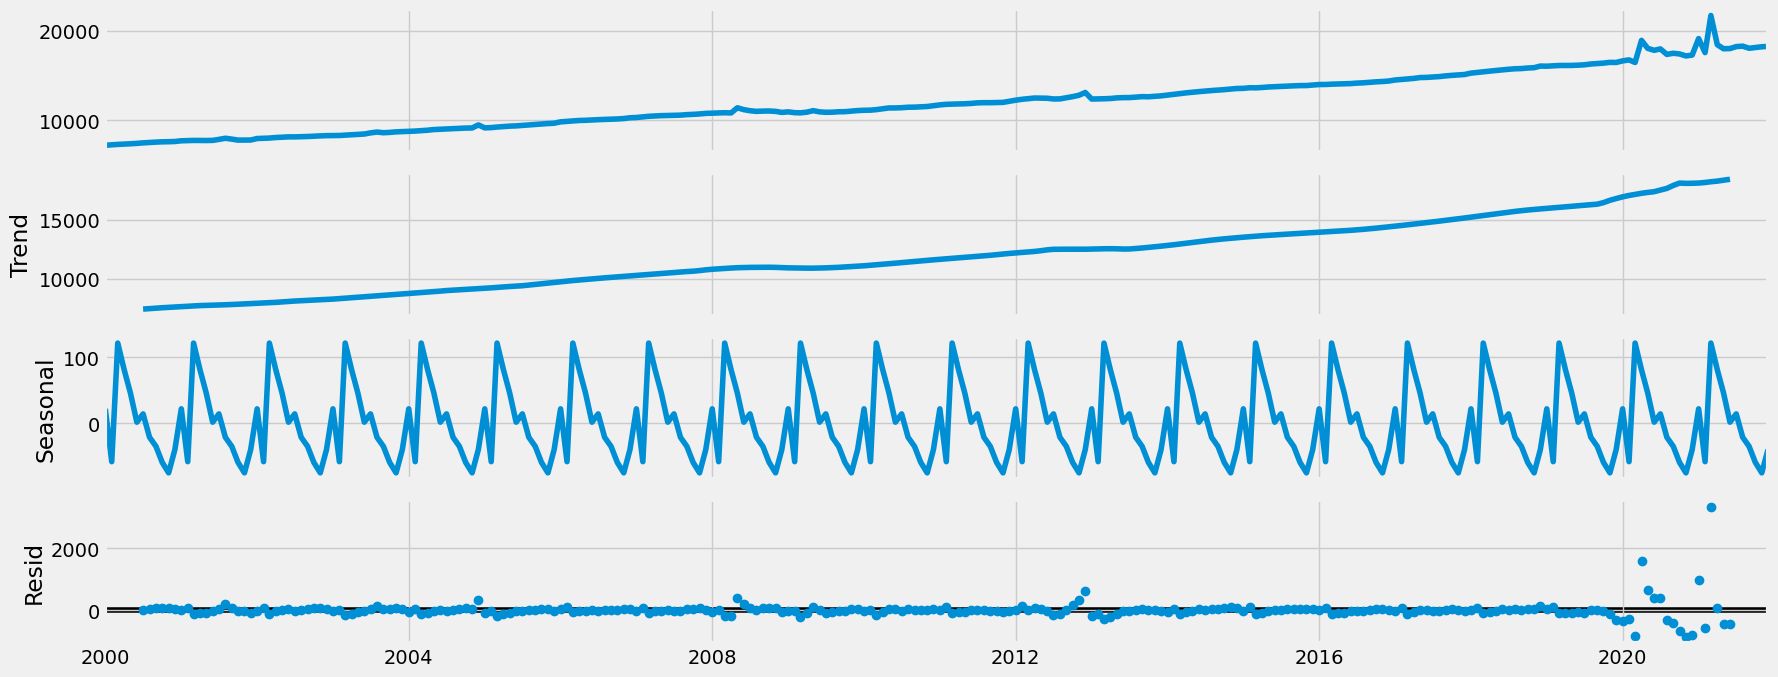

In [27]:
# Plot the separate components

decomposition.plot()
plt.show()

The trend is increasing meaning as disposable income is increasing over the years. There is not much noise but can see a increase in 2020.

### Test for stationarity 

In [28]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.667807
p-value                          0.989173
Number of Lags Used             16.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


The Dickey-Fuller Stationary test proves that data is non-stationary:

The test stats is larger then the critical value of 5% can not reject the null 
The p-vaule is high over .05 and is not significant and can not reject the null 

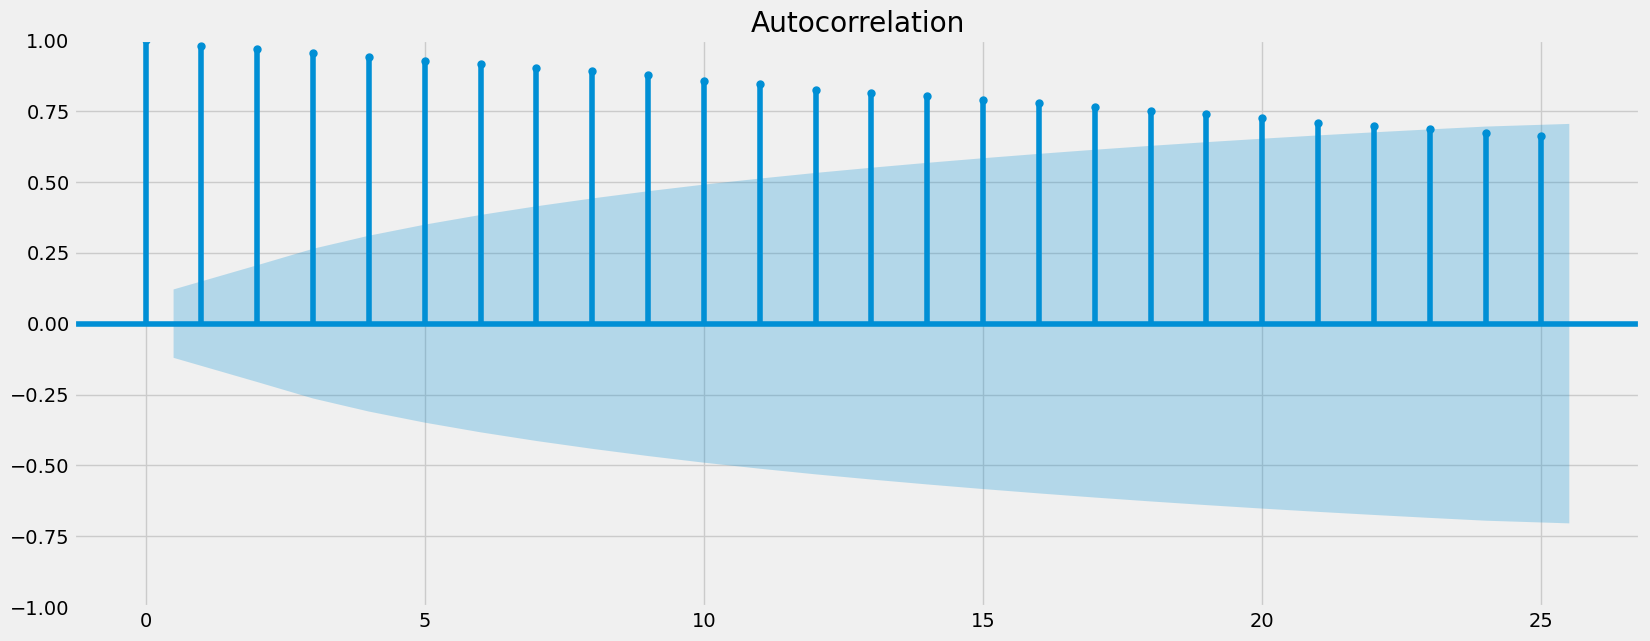

In [29]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means the lags are significantly correlated with each other. 

We have many lags beyond this interval, and can deduce that this data is non-stationary.

### Stationarzing the Data

In [30]:
data_diff = data_sub - data_sub.shift(1)

In [31]:
#remocing missing values that come from differencing 
data_diff.dropna(inplace = True) 

In [32]:
data_diff.head()

,Value
datetime,
2000-02-01,50.5
2000-03-01,50.7
2000-04-01,31.2
2000-05-01,36.5
2000-06-01,45.3


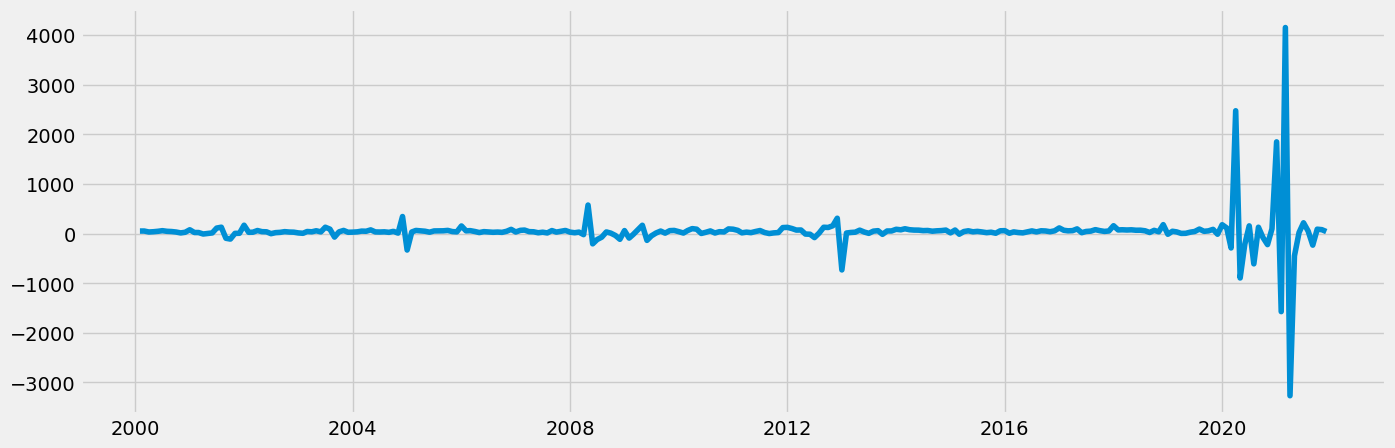

In [33]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [34]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.223922
p-value                          0.018641
Number of Lags Used             16.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


Dickey Fuller Test proves that data is Stationary:


Test Stat is smaller the the Critical Vaule of 5% therefore can reject the null and data is stationary 
P-vaule is less than 0.05 therefore it is significant. 

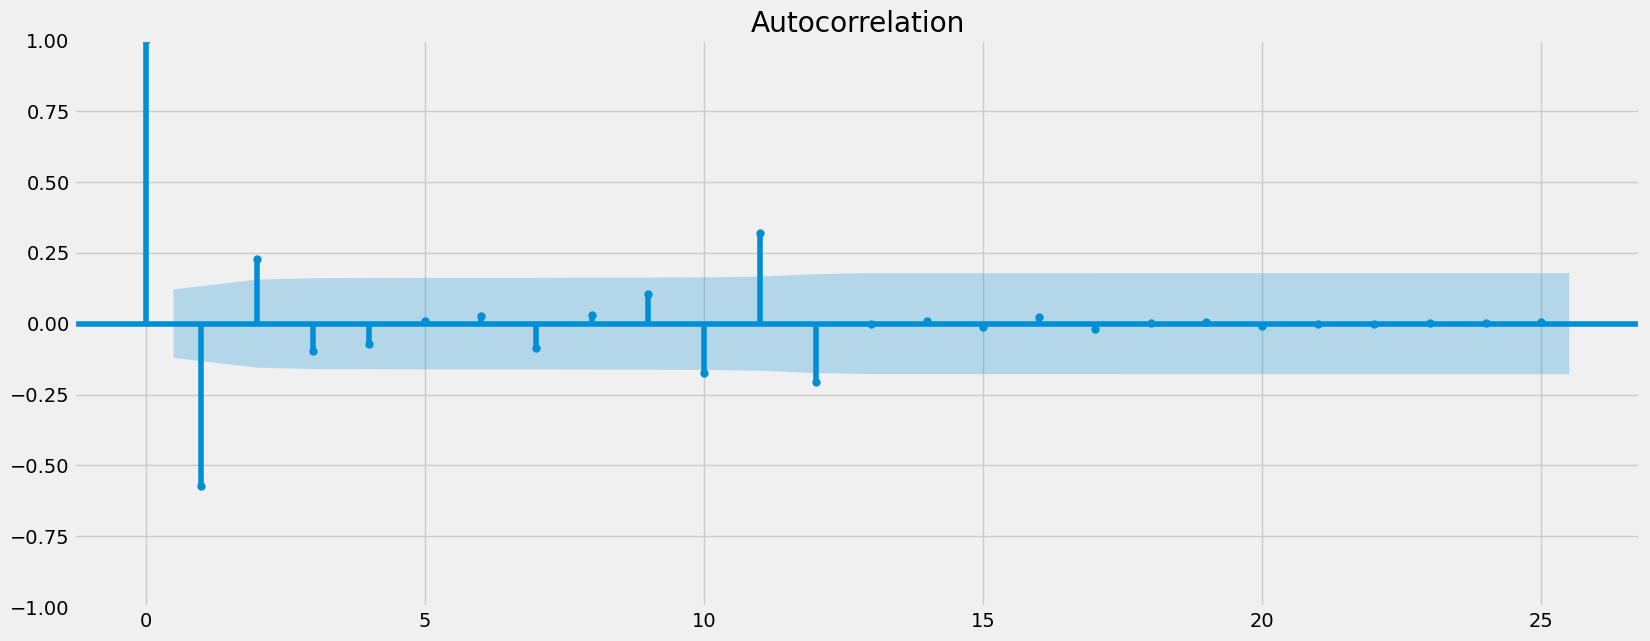

In [35]:
plot_acf(data_diff)
plt.show()

We have lags under the blue line which mean that it is stationary but it is a weak stationary. We could not do another round of differencing because we do not have enough lags above the line to run a second round. 


While the Dickey Fuller test stats that the data is stationary the autocorrelation shows that it is weak.